<a href="https://colab.research.google.com/github/Gab2697/Human-Activity-Recognition/blob/master/Test_otherDS_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import
from tensorflow import keras
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from scipy import signal
import torch

from keras import layers 
from keras import models
from tensorflow.keras.utils import to_categorical

#Other dataset: load data

In [46]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [47]:
y_train

array([-1,  1, -1, ..., -1,  1, -1])

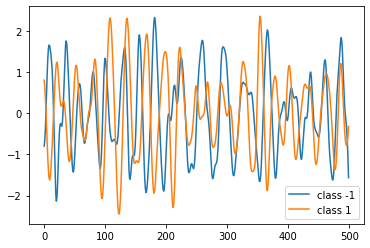

In [48]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [58]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [49]:
num_classes = len(np.unique(y_train))
num_classes

2

In [59]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]
x_train.shape

(3601, 500, 1)

In [60]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [61]:
y_train.shape
y_train2= to_categorical(y_train, 2)
y_train2.shape

(3601, 2)

#Load my dataset-25 participants

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def open_pickle(path_pickle):
  f = open(path_pickle, 'rb')
  T = pickle.load(f)
  f.close()

  return T

In [5]:
#T13,T14,T15,T16,T17,T18,T19,T21,T22,T23,T25,T26,T27,T28
TTT=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/TTT.pickle')
#T3,T4,T5,T7,T8,T9,T10,T11,T12,T20,T24
T=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/TT.pickle')

#bring all into one
TT = tf.concat([T,TTT], axis=1)

TT.shape

TensorShape([7704, 3959, 6])

In [13]:
####need to train and test randomly
TT_shuffle_x=tf.random.shuffle(TT[:,:,0:4], seed=8)
TT_shuffle_y=tf.random.shuffle(TT[:,:,4], seed=8)


#========Initial cutting========(trials x frame x channels) 
#X-data with shape ((1926frames x 4sec)x(80trials x 2surfaces x n-participants) x 4channels)
X=TT_shuffle_x.numpy() 
#Y-categorical encoded label = 1 for asphalt and 0 for grass 
y=TT_shuffle_y.numpy() 
#number trials
num_trials= TT.shape[1]

#========Sreshaping into the specific intut format========S 
#keras CNN is looking for X= (batch_size, height, width,depth)
X_reshape = X.reshape((num_trials,7704, 4))
y=y.reshape((num_trials,7704))
print("Data shape:", X_reshape.shape) 
print("Label shape:", y.shape)

#========Splitting the data into training and testing sets========keep 4 participants for testing 
#data set for training and testing the model
train_size= int(0.8*num_trials) 
X_train= X_reshape[0:train_size,:,:]
X_test=X_reshape[train_size:num_trials,:,:]

#labels for train and test
y_train=y[0:train_size,:] 
y_test=y[train_size:num_trials,:]

# ========convert class vectors to binary class matrices========
label_train = to_categorical(y_train, 2)
label_test = to_categorical(y_test, 2)

#========only keeping one label for each trials========
#(instead of a complete vector of the same number)
label_train= label_train[:,0]
label_test=label_test[:,0]

print("Data shape train:",X_train.shape,"Data shape test:",X_test.shape,"Label shape train:",label_train.shape,"Label shape test:",label_test.shape)

Data shape: (3959, 7704, 4)
Label shape: (3959, 7704)
Data shape train: (3167, 7704, 4) Data shape test: (792, 7704, 4) Label shape train: (3167, 2) Label shape test: (792, 2)


# Build a baseline CNN with Conv2D

In [ ]:

def make_model_2D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size):
    #Instantiating a small convnet
    model = models.Sequential()
    #filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv2D(filter_numb1, kernel_size, activation='relu', input_shape=(input_size),padding='same')) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filter_numb2, kernel_size, activation='relu',padding='same'))
    model.summary()

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
    model.summary()

    return model 

# testing CNN model
num_trial_batch=20
model=make_model_2D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(x_train, y_train, epochs=3, batch_size=num_trial_batch,validation_split=0.1)

# Build a baseline CNN with Conv1D

In [38]:
def make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size):
    #Instantiating a small convnet
    model = models.Sequential()
    #filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv1D(filter_numb1, kernel_size, activation='relu', input_shape=(input_size),padding='same')) 
    model.add(layers.MaxPooling1D(pool_size))
    model.add(layers.Conv1D(filter_numb2, kernel_size, activation='relu',padding='same'))
    model.summary()

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options 
    model.summary()
    return model 


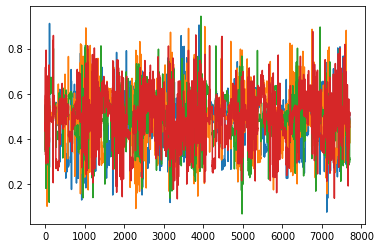

In [27]:
plt.plot(X_train[500])

In [ ]:
#============avec mon dataset============
#call function to build model
model=make_model_1D(X_train.shape[1:],32,64,64,3,2)
# testing CNN model
num_trial_batch=20
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=3, batch_size=num_trial_batch,validation_split=0.1)

In [55]:
print('my data set train shape:',X_train.shape, 'my label shape:',label_train.shape)

my data set train shape: (3167, 7704, 4) my label shape: (3167, 2)


In [62]:
print('other data set train shape:',x_train.shape, 'other label shape:',y_train2.shape)

other data set train shape: (3601, 500, 1) other label shape: (3601, 2)


In [63]:
#============avec un autre dataset============
#call function to build model
model=make_model_1D(x_train.shape[1:],32,64,64,3,2)
# testing CNN model
num_trial_batch=20
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(x_train, y_train2, epochs=3, batch_size=num_trial_batch,validation_split=0.1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 500, 32)           128       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 250, 32)          0         
 1D)                                                             
                                                                 
 conv1d_18 (Conv1D)          (None, 250, 64)           6208      
                                                                 
Total params: 6,336
Trainable params: 6,336
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 500, 32)           128       
                              